In [ ]:
%cd /home/ipanigra/Documents/Mask2Former/mask2former/modeling/pixel_decoder/ops
!python setup.py build install
%cd ../../../../

In [1]:
from mask2former import add_maskformer2_config
from mpl_toolkits import mplot3d
%matplotlib inline
import pickle as pkl
import numpy as np
import os
from PIL import Image
# from automate_seq_detection import get_change_det

In [ ]:
# beginner = np.array([[0,0]])
# with open(os.path.join(path,'sidewalks_withqueries'),'wb') as f:
#     pkl.dump(beginner, f)
# f.close()

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed May 26 19:29:34 2021

@author: tombu and Indu Panigrahi
"""

import numpy as np
from scipy.spatial import transform
import os
import matplotlib.pyplot as plt
import cv2
from utils import read_cameras, get_intrinsic, get_extrinsic, project_3d_points, filter_3d_points
import torch
from shapely.geometry import Polygon
import descartes

# detectron2 imports
import detectron2
from detectron2.utils.visualizer import _PanopticPrediction
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("mapillary_vistas_panoptic_val")
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")


class myPolygon:
    def __init__(self, mask, pts):
        self.mask = mask
        self.pts = pts
    
#     def toMask(self, img_shape=(720,1280)):
#         mask = np.zeros(img_shape, np.uint8)
#         print('hull points', self.hull_points)
#         mask = cv2.drawContours(mask, self.hull_points, -1, (255,255,255), -1)
#         return cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    def iogt(self, otherpoly):
        if otherpoly is None:
            print('No polygon provided for comparison.')
            return 0
        other_mask = otherpoly.mask
        return np.sum(np.logical_and(self.mask, other_mask)) / np.sum(self.mask)
    
    def iogt_pts(self, otherpoly):
        if otherpoly is None:
            print('No polygon provided for comparison.')
            return 0
        else:
            other_mask = set(zip(otherpoly.pts[:,0],otherpoly.pts[:,1]))
#             cv2.imshow('iogt',np.uint8(np.logical_and(self.mask, other_mask)*255))
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
#             this_mask = set(self.pts)
            this_mask = set(zip(self.pts[:,0],self.pts[:,1]))
            both_mask = this_mask.intersection(other_mask)
            return len(both_mask) / len(this_mask)
#             return np.sum(np.logical_and(self.mask, other_mask)) / np.sum(self.mask)
        

def init_detector(thresh = 0.8):
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_maskformer2_config(cfg)
    # mapillary vistas
    cfg.merge_from_file("configs/mapillary-vistas/panoptic-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_300k.yaml")
    cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/mapillary_vistas/panoptic/maskformer2_swin_large_IN21k_384_bs16_300k/model_final_132c71.pkl'
    cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
    cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
    cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True
    predictor = DefaultPredictor(cfg)
    return cfg, predictor


def get_detection(cam_path, predictor, args, show_img = True, show_polygon = False, save_img = False, sidewalk=True):
    im = cv2.imread(cam_path)
    sem_seg = predictor(im)["sem_seg"].to('cpu')
    stuff_classes = MetadataCatalog.get(args.cfg.DATASETS.TRAIN[0]).stuff_classes

    stuff_instances = []
    # detect sidewalk
    if sidewalk:
#         idx = (np.arange(len(stuff_classes)) == stuff_classes.index('Sidewalk'))
        idx = stuff_classes.index('Sidewalk')
    # detect snow
    else:
#         idx = (np.arange(len(stuff_classes)) == stuff_classes.index('Snow'))
        idx = stuff_classes.index('Snow')
#     stuff_instances = sem_seg[idx]
    detection = (sem_seg.argmax(0)==idx)
    if detection.max() > 0:
        stuff_instances.append(detection)
    
    polygons = []
    if len(stuff_instances) != 0:
        pred_mask = stuff_instances[0].numpy().astype('uint8')
        # exclude sidewalks on the other side of the road
        if sidewalk:
            midpt_x = detection.shape[1] // 2
            for i in range(midpt_x):
                pred_mask[:,i] = 0
        if pred_mask.max() > 0:
#             pred_mask_visualized = pred_mask*idx + 15
#             v = Visualizer(im[:, :, ::-1], coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
#             semantic_result = v.draw_sem_seg(pred_mask_visualized).get_image()
#             cv2.imshow('segmentation', semantic_result[:, :, ::-1])
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()

#             contours, hierarchy= cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#             print('findContours prints type', type(contours), 'and', contours)
#             cnt = np.concatenate(contours, axis = 0)
#             hull= cv2.convexHull(cnt)
#             hull = hull[:, 0, :]
#             points = np.array([(p0, p1) for (p0, p1) in zip(hull[:, 0], hull[:, 1])])

            polygons.append(myPolygon(pred_mask,np.ones((2,2))))
#             cv2.imwrite(str(sidewalk)+'.jpg',pred_mask*255)
#             cv2.imshow(str(idx),pred_mask*255)
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()

#             if len(points) > 3:
#                 poly = Polygon(points)
#                 polygons.append(poly)
#                 print(polygons[0].is_valid)

    if show_img:
        v = Visualizer(im[:, :, ::-1],
        metadata=MetadataCatalog.get('mvd'),
        scale=0.5,
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(num = 2)
        plt.imshow(out.get_image())
    if save_img:
        v = Visualizer(im[:, :, ::-1],
        metadata=MetadataCatalog.get('mvd'),
        scale=1,
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        parent = os.path.dirname(cam_path).split('/')[-2]
        os.makedirs(os.path.join(args.out_path, parent), exist_ok=True)    
        predictions = outputs["instances"].to("cpu")            
        cv2.imwrite(os.path.join(args.out_path, parent, os.path.basename(cam_path)), out.get_image()[:, :, ::-1])
        
    if show_polygon:
        fig = plt.figure(figsize=(9, 16))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xlim(0, im.shape[1])
        ax.set_ylim(im.shape[0], 0)
        ax.imshow(im[:, :, [2, 1, 0]])
        for poly in polygons:
            ax.add_patch(descartes.PolygonPatch(poly))

    return polygons

def iogt(gt, pred):
    """
    return intersection over the ground truth
    """    
    # Calculate Intersection and union, and tne IOU
    polygon_intersection = gt.intersection(pred).area
    gt_area = gt.area
    iogt = polygon_intersection / gt_area 
    return iogt

def get_3d_points(path):
    """
    Parameters
    ----------
    path : str
        DESCRIPTION.

    Returns
    -------
    points3d : float16
        x, y, z, 3d ID of 3d points in the world frame.

    """
    # 3D point list with one line of data per point:
    #   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
    #TRACK[] is a list of images and their points which contain the 3D point
    path  = os.path.join(path, 'points3D.txt')
    points3d = np.loadtxt(path, usecols = (1, 2, 3, 0, 4, 5, 6))
    points3d = points3d[(points3d[:, 4] == 0) & (points3d[:, 5] == 255) & (points3d[:, 6] == 0), :4]
    return points3d

def read_image_points(path):
    """
    input: root path
    
    returns
    ---------
    imgto2dfeatures
        dictionaries of image file names to the 2D features 
    """     
    imgto2dfeatures = {}
    path  = os.path.join(path, 'images.txt')
    with open(path) as f:
        lines = f.read().splitlines()

    # Image list with two lines of data per image:
    #   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
    #   POINTS2D[] as (X, Y, POINT3D_ID)
    for i,line in enumerate(lines):
        if line[0] == '#':
            continue
        else:
            if i % 2 == 0:
                fields = line.split(' ')
                #NAME
                image_name = os.path.basename(fields[-1])
                #IMAGE_ID
                image_id = int(fields[0])                
            else:
                fields = line.split(' ')
                points_2d = np.array([float(pt) for pt in fields])
                points_2d = np.reshape(points_2d, (-1, 3))
                #maps the name to 2d points in the image
                imgto2dfeatures[image_id] = points_2d
    return imgto2dfeatures

def read_images(path):
    """
    input: root path
    returns: images: IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID
             names: list of image file names 
    """     
    path  = os.path.join(path, 'images.txt')
    images = np.loadtxt(path, usecols = (0, 1, 2, 3, 4, 5, 6, 7, 8))
    images = images[::2]
    names = np.loadtxt(path, usecols = (9), dtype='str')
    names = names[::2]
    names = names.tolist()
    
    return images, names

def get_projections(name, names, images, cameras, points, force_pinhole = True, show_img = False, cam_path = None):
    '''
    get the points that are projected into the image. return the pixel coordinates in the image frame as well as the 3D point ID 

    Parameters
    ----------
    name : str
        name of the image.
    names : list
        list of all images.
    images : array
        image pose array.
    cameras : array
        camera intrinsics array.
    force_pinhole : TYPE, optional
        if you want to force a pinhole camera model. The default is True.

    Returns
    -------
    pixel_full : array (n x 3)
        pixel coordinates of 3D point projections.
    id3d_full : array (n x 1)
        3D point IDs

    '''
    i = names.index(name)
    image = images[i]
    image_id = int(image[0])
    
    pose = image[1:8]
    cameraID = int(image[8])
    
    intrinsic = cameras[cameras[:, 8] == cameraID, :].flatten()
    
    #camera parameters
    extrinsic = get_extrinsic(pose)
    pixel_full, id3d_full = project_3d_points(points, extrinsic, intrinsic, force_pinhole = force_pinhole)
    
    # checking something
#     print('MAX GROUND PIXEL IN IM', np.amax(pixel_full[:,0]))
#     ground_points_in_image = np.zeros((720,1280))
#     pixel_full_int = pixel_full.astype(int)
#     ground_points_in_image[pixel_full_int[:,1], pixel_full_int[:,0]] = 1
# #     for (p0,p1) in pixel_full:
# #         if p0>=0 and p0<1280:
# #             if p1>=0 and p1<720:
# #                 ground_points_in_image[int(p1),int(p0)] = 1
#     cv2.imshow('ground_points_in_image',ground_points_in_image*255)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    if show_img:
        assert cam_path is not None
        im = cv2.imread(cam_path)

        plt.figure(num = 2)
        plt.scatter(pixel_full[:, 0], pixel_full[:, 1])
        plt.imshow(im[:, :, [2, 1, 0]])

    return pixel_full, id3d_full

def get_position(name, names, images):
    '''
    get the location of the camera in x, y, z coordinates
    
    Parameters
    ----------
    name : str
        name of the image.
    names : list
        list of all images.
    images : array
        image pose array.
        
    Returns
    -------
    position : array (3 x 1)
        3D location of the camera
    '''
    i = names.index(name)
    image = images[i]
    image_id = int(image[0])
    pose = image[1:8]
    
    q = pose[:4]
    #make scalar last
    q = q[[1, 2, 3, 0]]
    #get rotation matrix from the quaternion. world to cam
    R_w2c = transform.Rotation.from_quat(q)
    
    # world to cam translation
    t= pose[4:]
    
    position = - R_w2c.as_matrix().T.dot(t) 

    
    return position

def find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr):
    '''
    return the homography matrix that converts the ground plane of the current frome into the reference frame
    Parameters:
    pixel_ref : array (n x 3)
        pixel coordinates of 3D point projections.
    id3d_ref : array (n x 1)
        3D point IDs
    pixel_curr : array (n x 3)
        pixel coordinates of 3D point projections.
    id3d_curr : array (n x 1)
        3D point IDs
    '''
    _, idx_ref, idx_curr = np.intersect1d(id3d_ref.flatten(), id3d_curr.flatten(), return_indices=True)

    pixel_ref = pixel_ref[idx_ref, :]
    pixel_curr = pixel_curr[idx_curr, :] 
    if len(pixel_ref) >= 4 and len(pixel_curr) >= 4:
        M, status = cv2.findHomography(pixel_curr[:, :2], pixel_ref[:, :2], cv2.RANSAC)
        return M
    else:
        return None

def transform_points(curr_detection, M, cam_path = None, show_polygon = False, use_mask=True):
    if M is None:
        "failed homography"
        return []
    polygons = []
    for poly in curr_detection:
        if use_mask:
            hull = np.argwhere(poly.mask)[:,[1,0]]
        else:
            hull = poly.pts
#         hull = np.array(poly.exterior.coords[:-1]) # makes 2D numpy array of x,y? coords, the -1 was for removing the repeated point
        hull = np.concatenate((hull, np.ones((hull.shape[0], 1))), axis = 1)
        hull = hull.T
        hull = M @ hull
        hull = hull.T
        hull = hull/hull[:, 2:3]
        points = [(p0, p1) for (p0, p1) in zip(hull[:, 0], hull[:, 1])]
        transformed_mask = np.zeros((720,1280))
        print('sample point', points[0])
        # checking something
        cnt = 0
        for (p0,p1) in points:
            if p0>=0 and p0<1280:
                if p1>=0 and p1<720:
                    transformed_mask[int(p1),int(p0)] = 1
                    cnt+=1
        print('proportion', cnt / len(points))
#         cv2.imshow('Image',transformed_mask*255)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
#         pixel_coords = np.array([(p1,p0) for (p0,p1) in points])
#         transformed_mask[pixel_coords] = 1
        if use_mask:
            poly = myPolygon(poly.mask, np.array(points))
        else:
            poly = myPolygon(transformed_mask, np.array(points))
        polygons.append(poly)
#         if poly.is_valid:
#             polygons.append(poly)
#         else:
#             print('error in transformed polygon')
        
    if show_polygon and cam_path != None:
        im = cv2.imread(cam_path)
        fig = plt.figure(figsize=(9, 16))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xlim(0, im.shape[1])
        ax.set_ylim(im.shape[0], 0)
        ax.imshow(im[:, :, [2, 1, 0]])
        for poly in polygons:
            ax.add_patch(descartes.PolygonPatch(poly))
    return polygons

def transform_points_toimage(curr_detection, M, cam_path = None, show_polygon = False):
    if M is None:
        "failed homography"
        return []
    polygons = []
    for poly in curr_detection:
        hull = poly.pts
#         hull = np.array(poly.exterior.coords[:-1]) # makes 2D numpy array of x,y? coords, the -1 was for removing the repeated point
        hull = np.concatenate((hull, np.ones((hull.shape[0], 1))), axis = 1)
        hull = hull.T
        hull = M @ hull
        hull = hull.T
        hull = hull/hull[:, 2:3]
        points = [(p0, p1) for (p0, p1) in zip(hull[:, 0], hull[:, 1])]
        
        transformed_mask = np.zeros((720,1280))
        print('sample point', points[0])
        
        # filter off-image projections
        def filter_proj(p):
            return (p[0]>=0 and p[0]<1280) and (p[1]>=0 and p[1]<720)
        points = np.array(points)
        in_image = np.apply_along_axis(filter_proj, 1, points)
        points_in_img = points[in_image].astype(int)
        transformed_mask[points_in_img[:,1],points_in_img[:,0]] = 1
#         for (p0,p1) in points:
#             if p0>=0 and p0<1280:
#                 if p1>=0 and p1<720:
#                     transformed_mask[int(p1),int(p0)] = 1
#                 else:
#                     points.remove((p0,p1))
#             else:
#                 points.remove((p0,p1))
        
        # filter off-image projections
#         for (p0,p1) in points:
#             if not ((p0>=0 and p0<1280) and (p1>=0 and p1<720)):
#                 points.remove((p0,p1))
                    
#         cv2.imshow('Image',transformed_mask*255)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
#         pixel_coords = np.array([(p1,p0) for (p0,p1) in points])
#         transformed_mask[pixel_coords] = 1
        poly = myPolygon(transformed_mask, np.array(points))
        polygons.append(poly)
#         if poly.is_valid:
#             polygons.append(poly)
#         else:
#             print('error in transformed polygon')
        
    if show_polygon and cam_path != None:
        im = cv2.imread(cam_path)
        fig = plt.figure(figsize=(9, 16))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_xlim(0, im.shape[1])
        ax.set_ylim(im.shape[0], 0)
        ax.imshow(im[:, :, [2, 1, 0]])
        for poly in polygons:
            ax.add_patch(descartes.PolygonPatch(poly))
    return polygons
    
def sum_dict(total, single):
    for key, value in single.items():
        total[key] = value + total.get(key, 0)
    return total

def determine_valid_distance(position, center, coef, multiplier = 3):
    '''
    determine if a detection is close enough to the car to be considered an accurate detection

    Parameters
    ----------
    position : np.array (3,)
        position of the camera.
    center : np.array (3,)
        centroid of the detection. we assuem that the detection's height is 0.
    coef : np.array(4, 1)
        coefficients of the plane
    Returns
    -------
    TYPE: booleon
        is the detection within a certain multiple of the camera height.

    '''
    l2_dist = np.linalg.norm(position-center)
    # cam_height = position[2]
    cam_height = dist(position[np.newaxis, :], coef)
    return l2_dist < cam_height * multiplier

def dist(data, coef):
    A = np.ones((data.shape[0], 1))
    A = np.concatenate([data, A], axis = 1)
    d = np.abs(np.dot(A, coef)) / np.sqrt(np.sum((coef ** 2)[:3]))
    return d

def fit_plane(data):
    A = np.ones((data.shape[0], 1))
    A = np.concatenate([data, A], axis = 1)
    u, s, vt = np.linalg.svd(A, full_matrices=False)
    coef = vt[3, :]    
    return coef

def iou(poly1, poly2):
    """
    return intersection over union
    """
    polygon_intersection = poly1.intersection(poly2).area
    # polygon_union = poly1.union(poly2).area
    # polygon_union = min(poly1.area, poly2.area)
    polygon_union = poly1.area + poly2.area
    IOU = polygon_intersection / polygon_union 
    return IOU



def nms(total_poly, total_scores, thresh_iou=0.8):
    """
    perform nms on polygons

    Parameters
    ----------
    total_poly : list
        polygons.
    total_scores : list
        scores.
    thresh_iou : int, optional
        DESCRIPTION. The default is 0.8.

    Returns
    -------
    keep_poly : list
        polygons.
    keep_score : list
        scores.

    """
    P = total_poly

    # we extract the confidence scores as well
    scores = np.array(total_scores)

    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for 
    # filtered prediction boxes
    keep_poly = []
    keep_score = []
    keep_idx = []

    while len(order) > 0:
        
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        keep_poly.append(P[idx])
        keep_score.append(total_scores[idx])
        keep_idx.append(idx)
        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break
        
        
        poly2 = P[idx]
        
        IoU = []
        for i in order:
            poly1 = P[i]   
            IoU.append(iou(poly1, poly2))
        IoU = np.array(IoU)

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
    
    return keep_poly, keep_score, keep_idx


def perform_multi_image_check(total_poly, total_scores, image_id, thresh_iou = 0.1, multi_image_threshold = 3):
    keep_poly = []
    keep_score = []
    index = []
    for i in range(len(total_poly)):
        seen_across_n_images = 1
        for j in range(len(total_poly)):
            if image_id[i] != image_id[j]:
                IoU = iou(total_poly[i], total_poly[j])
                if IoU > thresh_iou:
                    seen_across_n_images += 1
                    if seen_across_n_images >= multi_image_threshold:
                        keep_poly.append(total_poly[i])
                        keep_score.append(total_scores[i])
                        index.append(i)
                        break
    return keep_poly, keep_score, index

def change_detection(parent, args, check_valid_distance = False):
    
    points = get_3d_points(os.path.join(args.path, parent))
    points = points[::5, :]
    
    print('max points', np.amax(points))
    print('min points', np.amin(points))
    
    
    coef = fit_plane(points[:, :3])
    
    id3d_ref = points[:, 3:4]
    pixel_ref = points[:, 0:2]
    
#     print('max pixel ref', np.amax(pixel_ref))
#     print('min pixel ref', np.amin(pixel_ref))
    
    images, names = read_images(os.path.join(args.path, parent))
    cameras = read_cameras(os.path.join(args.path, parent), subdir = '')
    
    logs = {}
    logs['query_img'] = [args.curr_img]
    logs['camera3'] = [args.curr_img]
#     for i in names:
#         date = i.split('/')[0]
#         if date not in logs.keys():
#             logs[date] = []
#         logs[date].append(i)
    change_logs = logs
   
    ############## plot detection for all sequences ############### 
    if args.debug:
        track_det = []
    log_poly = {}
    #'2015_04_07', '2017_02_04', '2019_09_26', '2021_06_16'
    change_logs = ['query_img', 'camera3']
    for curr_log in change_logs:
        # curr_log = '2019_09_26'
        # total_poly = []
        # total_scores = []
        # image_id = []
        for curr_img in logs[curr_log]:
            # detect sidewalk
            if curr_log == 'camera3':
                continue
                print('IMAGE NAME', curr_img)
                curr_path = os.path.join(args.img_path, 'clear2', curr_img)
                curr_detection = get_detection(cam_path = curr_path, predictor = args.predictor, show_img = False, save_img = args.save_pred, args = args)
            # detect snow
            else:
#                 continue
                curr_path = os.path.join(args.img_path, 'cleared2', curr_img)
                print('IMAGE NAME', curr_img)
                curr_detection = get_detection(cam_path = curr_path, predictor = args.predictor, show_img = False, save_img = args.save_pred, args = args, sidewalk=False)
                # temporary nest
                pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)
                M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)
                curr3d_detection = transform_points(curr_detection, M, None, False)
                if curr_log == 'camera3':
#                     with open(os.path.join(args.path,'sidewalks_withqueries'),'rb') as f:
#                         sidewalk_pts = pkl.load(f)
#                     f.close()
#                     new_sidewalk_pts = np.append(sidewalk_pts, np.array(curr3d_detection[0].pts),axis=0)
#                     with open(os.path.join(args.path,'sidewalks_withqueries'),'wb') as f:
#                         pkl.dump(new_sidewalk_pts, f)
#                     f.close()
                    min_sidewalk = np.amin(np.array(curr3d_detection[0].pts)[:,0])
                    max_sidewalk = np.amax(np.array(curr3d_detection[0].pts)[:,0])
                    print('SIDEWALK X RANGE: (' + str(min_sidewalk) + ', ' + str(max_sidewalk) + ')')
    #             plt.title('Debug')
    #             plt.scatter(pixel_ref[:,0], pixel_ref[:,1], c='blue')
    #             plt.scatter(curr3d_detection[0].pts[:,0], curr3d_detection[0].pts[:,1], c='red')
    #             plt.show()
                log_poly[curr_log] = curr3d_detection
                # end temporary nest
        
        for curr_img in logs['camera3']:
            curr_path = os.path.join(args.img_path, 'cleared2', curr_img)
            pixel_curr, id3d_curr = get_projections(curr_img, names, images, cameras, points, force_pinhole = True)

            # project saved sidewalk points
            M = find_homography(id3d_ref, pixel_ref, id3d_curr, pixel_curr)
            inv_M = find_homography(id3d_curr, pixel_curr, id3d_ref, pixel_ref)

            with open(os.path.join(args.path,'sidewalks_withqueries'),'rb') as f:
                sidewalk_pts = pkl.load(f)
            f.close()

            curr_detection = [myPolygon(None, sidewalk_pts[1:,:])]
            # filter saved sidewalk points
            curr3d_detection = transform_points_toimage(curr_detection, inv_M, None, False)
            # project saved sidewalk points or could just compare masks
#             curr3d_detection = transform_points(curr3d_detection, M, None, False, use_mask=False)

#             plt.title('Debug')
#             plt.scatter(pixel_ref[:,0], pixel_ref[:,1], c='blue')
#             plt.scatter(curr3d_detection[0].pts[:,0], curr3d_detection[0].pts[:,1], c='red')
#             plt.show()
            log_poly['camera3'] = curr3d_detection
    
    ############### perform change detection ##################
    
    curr_log = 'query_img'
    ref_log = 'camera3'
    ref_detection = log_poly[ref_log]
    curr_detection = log_poly[curr_log]

    # check if sidewalk is covered in snow
    covered = []
    clear = []    
    for gt_poly in ref_detection:
        seen = False
        for pred_poly in curr_detection:
            curr_iogt = gt_poly.iogt(pred_poly)
            print('IoGT', curr_iogt)
            
            ### save image ###
            sidewalk = gt_poly.mask
            snow = pred_poly.mask
            im = np.array(Image.open(os.path.join(args.img_path, 'cleared2', curr_img)))
            
            sidewalk_array = np.zeros((720,1280,3))
            for c in range(3):
                sidewalk_array[:,:,c] = sidewalk
                
            snow_array = np.zeros((720,1280,3))
            for c in range(3):
                snow_array[:,:,c] = snow
                
            sidewalk_px = np.logical_and(np.logical_xor(sidewalk_array, snow_array), sidewalk_array)*1
            snow_px = snow_array.astype(int)
            im_px = np.logical_not(np.logical_or(sidewalk_px, snow_px))*1
            
            sidewalk_px[:,:,2]*=249 #255
            sidewalk_px[:,:,1]*=215 #213
            sidewalk_px[:,:,0]*=28 #139

#             snow_px[:,:,2]*=141
#             snow_px[:,:,1]*=186
#             snow_px[:,:,0]*=206
            snow_px[:,:,2]*=0
            snow_px[:,:,1]*=50
            snow_px[:,:,0]*=200

            im_px[:,:,2]*=im[:,:,0]
            im_px[:,:,1]*=im[:,:,1]
            im_px[:,:,0]*=im[:,:,2]
            
            im_px_removed = np.logical_or(sidewalk_px, snow_px)*1
            im_px_removed[:,:,2]*=im[:,:,0]
            im_px_removed[:,:,1]*=im[:,:,1]
            im_px_removed[:,:,0]*=im[:,:,2]
            
            res = cv2.addWeighted(im_px_removed, 0.75, snow_px+sidewalk_px, 0.25, 1.0)
#             res = cv2.addWeighted(res, 0.5, sidewalk_px, 0.5, 1.0)
            
#             plt.imshow(sidewalk_px+snow_px+im_px) 
            plt.imshow(res+im_px)
#             cv2.imwrite('results.jpg',sidewalk_px+snow_px+im_px)
#             cv2.imwrite('results.jpg',res+im_px)
            ### end save image ###
            
            if seen:
                continue
            if curr_iogt > 0.5:
                seen = True
                covered.append(gt_poly)
            else:
                print('Debug')
#                 fig = plt.figure()
#                 ax = plt.axes(projection='3d')
#                 ax.scatter3D(points[:,0], points[:,1], points[:,2], c='gray');
#                 ax.scatter3D(gt_poly.pts[:,0], gt_poly.pts[:,1], gt_poly.pts[:,2], c='gold');
#                 ax.scatter3D(pred_poly.pts[:,0], pred_poly.pts[:,1], pred_poly.pts[:,2], c='blue');
#                 plt.show()
#                 with open(os.path.join(args.path,'sidewalks'),'rb') as f:
#                     sidewalk_pts = pkl.load(f)
#                 f.close()
                fig, ax = plt.subplots(1, 3, figsize=(15,7))
                ax[0].scatter(points[:,0], points[:,1], c='gray')
                ax[0].scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='gold',s = 0.01)
#                 ax[0].scatter(gt_poly.pts[:,0], gt_poly.pts[:,1], c='gold',s = 0.01)
                ax[0].scatter(pred_poly.pts[:,0], pred_poly.pts[:,1], c='blue',s = 0.01)
                # sidewalk
                ax[1].scatter(points[:,0], points[:,1], c='gray')
#                 ax[1].scatter(gt_poly.pts[:,0], gt_poly.pts[:,1], c='gold', s=0.01)ii
                ax[1].scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='gold',s = 0.01)
                # snow
                ax[2].scatter(points[:,0], points[:,1], c='gray')
                ax[2].scatter(pred_poly.pts[:,0], pred_poly.pts[:,1], c='blue', s=0.01)
#                 plt.setp(ax, xlim=(-1,1), ylim=(-10,10))
                plt.show()
#                 plt.savefig(os.path.join(args.path, parent, 'bev.jpg'))
        if seen == False:
            clear.append(gt_poly)

    # visualize change
    from matplotlib.patches import Patch
    fig = plt.figure(figsize=(9, 16))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_title('{} to {}'.format(ref_log.split('_')[0], curr_log.split('_')[0]))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('equal')
    ax.scatter(points[:, 0], points[:, 1], s = 0.01)
    for poly in clear:
#         pts = np.argwhere(poly.mask)[:,[1,0]]
        with open(os.path.join(args.path,'sidewalks_withqueries'),'rb') as f:
            sidewalk_pts = pkl.load(f)
        f.close()
#         ax.scatter(sidewalk_pts[:,0], sidewalk_pts[:,1], c='green',s = 0.01)
        ax.scatter(poly.pts[:,0], poly.pts[:,1], s = 0.01, c='gold')
#         ax.add_patch(descartes.PolygonPatch(poly, fc = 'g'))
    for poly in covered:
#         ax.add_patch(descartes.PolygonPatch(poly, fc = 'b'))
#         pts = np.argwhere(poly.mask)[:,[1,0]]
        ax.scatter(poly.pts[:,0], poly.pts[:,1], s = 10, c='b')        
    r = Patch(facecolor='b', label='covered')
    g = Patch(facecolor='gold', label='clear')
    ax.legend(handles=[r, g])
    plt.show()

    plt.savefig(os.path.join(args.path, parent, 'change.jpg'))

    
    #save another figure to show the difference between the detections 
    for poly in ref_detection:
        ax.add_patch(descartes.PolygonPatch(poly, fc = 'y'))        
    for poly in curr_detection:
        ax.add_patch(descartes.PolygonPatch(poly, fc = 'm'))                  
    m = Patch(facecolor='m', label='query')
    y = Patch(facecolor='y', label='ref')
    if args.removal:
        ax.legend(handles=[r, g, m, y])
    else:
        ax.legend(handles=[r, g, m, y])
    
    plt.savefig(os.path.join(args.path, parent, 'change_debug.jpg'))
    
    # plt.show()
    if len(covered) > 0:
        return 1, None
    else:
        return 0, None
    return 0, None

class Argument:
    def __init__(self, path, out_path, img_path, debug, save_pred, removal):
        self.path = path
        self.out_path = out_path
        self.img_path = img_path
        self.debug = debug
        self.save_pred = save_pred
        self.removal = removal

def get_change_det(curr_img, path, out_path, img_path, modelpath, debug = False, save_pred = False, multi_image = False, removal = False, threshold = 0.95):
    args = Argument(path, out_path, img_path, debug, save_pred, removal)
    cfg,predictor = init_detector(thresh=threshold) 
    args.predictor = predictor
    args.multi_image = multi_image
    args.cfg = cfg
    args.curr_img = curr_img
    return change_detection('', args)

def visualize_res():
    sfm_path = '/home/xinhez/Downloads/gabriel-BusEdge/server/engines/sfm_docker/sfm/2022_01_30/'
    group = 'camera3_1622586554_223433596'
    sfm_estimated_ground_output = sfm_path + '{}/sparse/plane_segmentation'
    sfm_img_path = sfm_path + '{}/images'
    model_path = "/home/xinhez/Downloads/gabriel-BusEdge/server/engines/sfm_docker/model/crosswalk_detector/model_final.pth"
    debug = True
    change = get_change_det(sfm_estimated_ground_output.format(group), sfm_estimated_ground_output.format(group), sfm_img_path.format(group), model_path, debug)

In [6]:
path = './output_withqueries'
img_path = './img_coverage'
out_path = './out_coverage'

Loading config configs/mapillary-vistas/panoptic-segmentation/swin/../Base-MapillaryVistas-PanopticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


WARNING [08/03 14:04:12 mask2former.modeling.transformer_decoder.mask2former_transformer_decoder]: Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...
max points 999943.0
min points -13.078098720357746
IMAGE NAME camera3_1641584748_847558352.jpg
sample point (-0.3860974960245744, 2.571710544947528)
proportion 0.8041320481550561
sample point (704.5956101212033, 74.08896241018113)
sample point (704.5956101212033, 74.08896241018113)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoGT 0.360332185750703
Debug


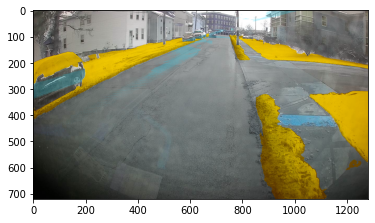

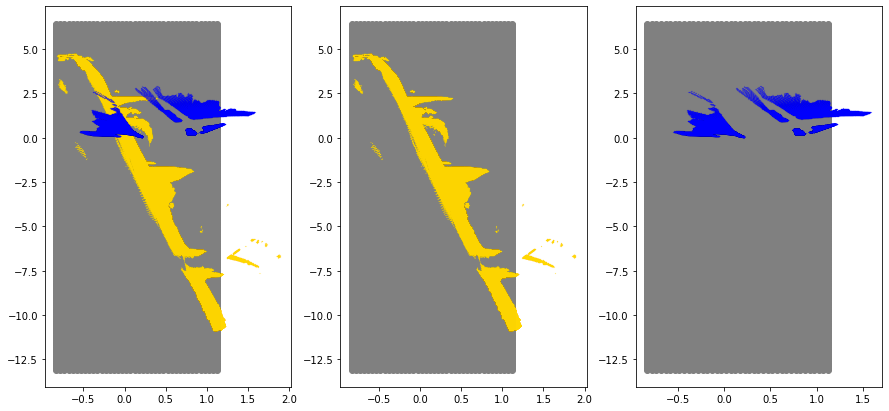

KeyboardInterrupt: 

In [7]:
import glob

images_snow = glob.glob('img_coverage/cleared2/*')
cnt = 0
# images_snow = ['some/folder/camera3_1641238928_551506552.jpg']
for i in images_snow:
    curr_img = i.split('/')[2]
    if get_change_det(curr_img, path, out_path, img_path, '')[0] == 0:
        cnt+=1
print('COUNT CORRECT =', cnt)
print('TOTAL =', len(images_snow))